## You're here! 
Welcome to your first competition in the [ITI's AI Pro training program](https://ai.iti.gov.eg/epita/ai-engineer/)! We hope you enjoy and learn as much as we did prepairing this competition.


## Introduction

In the competition, it's required to predict the `Severity` of a car crash given info about the crash, e.g., location.

This is the getting started notebook. Things are kept simple so that it's easier to understand the steps and modify it.

Feel free to `Fork` this notebook and share it with your modifications **OR** use it to create your submissions.

### Prerequisites
You should know how to use python and a little bit of Machine Learning. You can apply the techniques you learned in the training program and submit the new solutions! 

### Checklist
You can participate in this competition the way you perefer. However, I recommend following these steps if this is your first time joining a competition on Kaggle.

* Fork this notebook and run the cells in order.
* Submit this solution.
* Make changes to the data processing step as you see fit.
* Submit the new solutions.

*You can submit up to 5 submissions per day. You can select only one of the submission you make to be considered in the final ranking.*


Don't hesitate to leave a comment or contact me if you have any question!

## Import the libraries

We'll use `pandas` to load and manipulate the data. Other libraries will be imported in the relevant sections.

In [34]:
import pandas as pd 
import datetime
import os
import seaborn as sns
from datetime import datetime
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xml.etree.ElementTree as Xet
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import random
import seaborn as sns
from datetime import datetime
pd.set_option("display.max_columns", None)

## Exploratory Data Analysis
In this step, one should load the data and analyze it. However, I'll load the data and do minimal analysis. You are encouraged to do thorough analysis!

Let's load the data using `pandas` and have a look at the generated `DataFrame`.

In [35]:
dataset_path = '/kaggle/input/car-crashes-severity-prediction/'
train_df = pd.read_csv(os.path.join(dataset_path,'train.csv'))
xtree = Xet.parse(os.path.join(dataset_path,'holidays.xml'))
weather_df = pd.read_csv(os.path.join(dataset_path,'weather-sfcsv.csv'))
weather_condition = weather_df['Weather_Condition'].unique()
weather_condition_dict = dict(zip(weather_condition, range(len(weather_condition))))
weather_df.replace({'Weather_Condition': weather_condition}, inplace=True)
print("The shape of the dataset is {}.\n\n".format(train_df.shape))
train_df.head()

The shape of the dataset is (6405, 29).




,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Severity,timestamp
0,0,37.762150,-122.405660,False,0.044,False,False,False,False,False,False,False,True,R,2,2016-03-25 15:13:02
1,1,37.719157,-122.448254,False,0.000,False,False,False,False,False,False,False,False,R,2,2020-05-05 19:23:00
2,2,37.808498,-122.366852,False,0.000,False,False,False,False,False,False,True,False,R,3,2016-09-16 19:57:16
3,3,37.785930,-122.391080,False,0.009,False,False,True,False,False,False,False,False,R,1,2020-03-29 19:48:43
4,4,37.719141,-122.448457,False,0.000,False,False,False,False,False,False,False,False,R,2,2019-10-09 08:47:00


We've got 6407 examples in the dataset with 14 featues, 1 ID, and the `Severity` of the crash.

By looking at the features and a sample from the data, the features look of numerical and catogerical types. What about some descriptive statistics?

The output shows desciptive statistics for the numerical features, `Lat`, `Lng`, `Distance(mi)`, and `Severity`. I'll use the numerical features to demonstrate how to train the model and make submissions. **However you shouldn't use the numerical features only to make the final submission if you want to make it to the top of the leaderboard.**

Data Minipulation


#/kaggle/input/car-crashes-severity-prediction/

cols = ["date", "description"]
rows = []

xmlparse = Xet.parse('/kaggle/input/car-crashes-severity-prediction/holidays.xml')
root = xmlparse.getroot()
for i in root:
    date = i.find("date").text
    description = i.find("description").text

    rows.append({"date": date,
                 "description": description})

df = pd.DataFrame(rows, columns=cols)


df.to_csv('./holidays.csv')

#Remove the duplicate from the weather
def StartCleanupWeather(df_weather):
    df_weather.drop_duplicates(subset=['Year', 'Day','Month','Hour'], keep='last',inplace=True)
    df_weather['Full Date']=df_weather['Year'].apply(lambda x:str(x)+'-')+df_weather['Month'].apply(lambda x:str(x)+'-')+df_weather['Day'].apply(lambda x:str(x)+' ')+df_weather['Hour'].apply(lambda x:str(x)+':0:0')
    #df_weather["Full Date"]=df_weather['Year']+'-'+df_weather['Day']+'-'+df_weather['Month']+' '+df_weather['Hour'])+':0:0'
    lmb=lambda x:datetime.datetime.timestamp(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    df_weather["Full Date With H"]=df_weather["Full Date"].apply(lmb)
def ParseTime(time):
    #remove dots from the date
    date=datetime.datetime.strptime(time.split('.')[0], '%Y-%m-%d %H:%M:%S')
    date = date.replace(second=0, minute=0)
    return datetime.datetime.timestamp(date)

def ParseTimeWithouthours(time):
    #remove dots from the date
    date=datetime.datetime.strptime(time.split('.')[0], '%Y-%m-%d %H:%M:%S')
    date = date.replace(second=0, minute=0,hour=0)
    return datetime.datetime.timestamp(date)

def ParseHolidayTimeWithouthours(time):
    date=datetime.datetime.strptime(time, '%Y-%m-%d')
    date = date.replace(second=0, minute=0,hour=0)
    return datetime.datetime.timestamp(date)

def StartCleanupTrain(df_train):
    df_train["Full Date With H"]=df_train["timestamp"].apply(ParseTime)
    df_train["Full Date Without H"]=df_train["timestamp"].apply(ParseTimeWithouthours)
    #remove duplicates based on the position and time
    df_train.drop_duplicates(subset=['Lat', 'Lng','Full Date With H'], keep='last',inplace=True)
    
def StartCleanupTest(df_test):
    df_test["Full Date With H"]=df_test["timestamp"].apply(ParseTime)
    df_test["Full Date Without H"]=df_test["timestamp"].apply(ParseTimeWithouthours)
    #remove duplicates based on the position and time
    #df_train.drop_duplicates(subset=['Lat', 'Lng','Full Date With H'], keep='last',inplace=True)
    
def StartCleanupHoliday(df_holidays):
    df_holidays["Full Date Without H"]=df_holidays["date"].apply(ParseHolidayTimeWithouthours)
    df_holidays.drop(["date","description"],axis=1,inplace=True)
    f= lambda x:True
    df_holidays['Is Holiday']=True
def FillOFFDays(df):
    for i,row in df.iterrows():

        date=datetime.datetime.strptime(row['timestamp'].split('.')[0], '%Y-%m-%d %H:%M:%S')
        if (date.strftime("%A")=='Saturday' or date.strftime("%A")=='Sunday') :
            df.at[i,'Is Holiday']=True
        elif row['Is Holiday']!=True:
            df.at[i,'Is Holiday']=False

def StartProcess(weatherfilePath,trainfilePath,holidayfilePath,ch=1):
    df_weather = pd.read_csv(weatherfilePath)
    StartCleanupWeather(df_weather)
    df_weather.to_csv('./weatherUpdated.csv')
    df_train = pd.read_csv(trainfilePath)
    if ch == 1:
        StartCleanupTrain(df_train)
    elif ch == 2 :
        StartCleanupTest(df_train)
    
    df_train.to_csv('./trainUpdated2.csv')
    #Merge based on the time stamp
    df_mergedata=pd.merge(df_train,df_weather,how='left',on=['Full Date With H'])
    df_mergedata.to_csv('./merged.csv')
    df_holiday = pd.read_csv(holidayfilePath)
    StartCleanupHoliday(df_holiday)
    df_holiday.to_csv('./holidayUpdated.csv')
    df_mergedata2=pd.merge(df_mergedata,df_holiday,how='left',on=['Full Date Without H'])
    df_mergedata2.to_csv('./merged2.csv')
    FillOFFDays(df_mergedata2)
    df_mergedata2.to_csv('./merged2WithOFFdays.csv')
    return df_mergedata2



df=StartProcess('../input/car-crashes-severity-prediction/weather-sfcsv.csv','../input/car-crashes-severity-prediction/train.csv','./holidays.csv')







def FillData(DataFrame,ColumnNameslist,func,ch=1):
  for i in range (len(ColumnNameslist)):
    if func ==1 :  # replcae True / False Values To Numeric representation
      DataFrame[ColumnNameslist[i]] = DataFrame[ColumnNameslist[i]] * 1
    elif func == 0 :  # replcae Nan Values With Mean
     DataFrame[ColumnNameslist[i]]= DataFrame[ColumnNameslist[i]].fillna((DataFrame[ColumnNameslist[i]].mean()))
    elif func ==3 :
        if ch == 1:
            DataFrame[ColumnNameslist[i]] = DataFrame[ColumnNameslist[i]].dropna(inplace=True)
        elif ch == 2:
            DataFrame[ColumnNameslist[i]] = DataFrame[ColumnNameslist[i]].fillna(random.choice(DataFrame[ColumnNameslist[i]].values.tolist()),inplace=True)



#Data Fram Normalization For teh Selected Featuers List(normlizationList)
def DataMormalization(dataframname,normlizationList):

  transformer = Normalizer().fit(dataframname[normlizationList])
  transformer
  Normalizer()
  Normalizer(copy=True, norm='l2')
  transformer.transform(dataframname[normlizationList])
  return dataframname



#ColumnsTF to replcae true and false Cloumns with Numeric Values 1 / 0
ColumnsTF = ['Bump', 'Crossing', 'Give_Way','Junction', 'No_Exit', 'Railway', 'Roundabout', 'Stop', 'Amenity']
#columnsmean Columns Names Wich Has Nan Values to replcae with Mean
columnsmean = ['Temperature(F)','Humidity(%)',	'Wind_Speed(mph)',	'Visibility(mi)'] 
#Replace DataFrame True False Values With Numeric Values
FillData(df,ColumnsTF,1)
#Replace DataFrame Nan Values With Numeric Values
FillData(df,columnsmean,0)
#drop String Cloumns Null Values 
stringNa = ['Weather_Condition']
FillData(df,stringNa,3)

#FillData(df)

df.describe()

#Feature Selection'
missing_values = df.isna().sum()
percentage = (missing_values/df.shape[0])*100
missing_percent = pd.DataFrame({"Number_of_missing_values":missing_values,"Percentage":percentage})
missing_percent.sort_values(by="Percentage",ascending = False)


#Dropping columns consists more then 40% missing values 
#Country is US in the whole dataset so we can drop it 
#Turning_Loop is False in the whole dataset so we can drop it 
#df.drop(["Precipitation(in)","Wind_Chill(F)"],axis=1,inplace=True)
#droping rows consists more then 10 missing values 
row_drop = df[df.isna().sum(axis=1)>=10].index
df.drop(row_drop,axis=0,inplace=True)


df=df.apply(preprocessing.LabelEncoder().fit_transform)

normlizationList = ['Distance(mi)',	'Humidity(%)','Lat','Lng','Side','Temperature(F)','Visibility(mi)']
for i in range(len(normlizationList)):
    df[normlizationList[i]]=(df[normlizationList[i]]-df[normlizationList[i]].mean())/(df[normlizationList[i]].std())

df.drop(columns='ID').describe()

df.drop(columns=['Full Date Without H','Year','Day','Month','Hour'],axis=1,inplace=True)

features = ['Lat','Lng','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Stop','Amenity','Side','Is Holiday','Temperature(F)','Humidity(%)','Wind_Speed(mph)','Visibility(mi)']

In [36]:
def extract_date(df, column_name, date_format):
    df[column_name] = pd.to_datetime(df[column_name], format=date_format)
    df['Year'] = pd.DatetimeIndex(df[column_name]).year
    df['Month'] = pd.DatetimeIndex(df[column_name]).month
    df['Day'] = pd.DatetimeIndex(df[column_name]).day
    if len(date_format) > 8:
        df['Hour'] = pd.DatetimeIndex(df[column_name]).hour
    df.drop([column_name], axis= 1, inplace=True)
   

In [37]:
def normalize_data(df, *args):
    for arg in args:
        df[arg] = (df[arg] - df[arg].mean())/df[arg].std()
        

In [38]:
def merge_data(data):
    extract_date(data, 'timestamp', '%Y-%m-%d %H:%M:%S')
    data = data.drop_duplicates(subset=data.keys(), keep='last')
    df = pd.merge(data, weather_df_wd,  how='left', left_on=['Year', 'Day', 'Month', 'Hour'], right_on = ['Year', 'Day', 'Month', 'Hour'])
    df.dropna(axis=0, subset=['Weather_Condition', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)'], inplace=True)
    df.fillna(value=df.mean(), inplace=True)
    df.replace({True: 1, False: 0, 'Yes': 1, 'No': 0, 'R': 1, 'L': 0}, inplace=True)
    df['Weather_Condition'].replace(df['Weather_Condition'].unique(),range(len(df['Weather_Condition'].unique())), inplace=True)
    normalize_data(df, 'Lat', 'Lng', 'Wind_Speed(mph)', 'Wind_Chill(F)', 'Temperature(F)', 'Visibility(mi)', 'Year')
    df['Humidity'] = df['Humidity(%)'] / 100
    df = pd.merge(df, holiday_df,  how='left', left_on=['Year', 'Day', 'Month'], right_on = ['Year', 'Day', 'Month'])
    df.fillna(0, inplace=True)
    return df

In [39]:
xroot = xtree.getroot()
df_cols = ['date', 'description']
rows = []
for node in xroot:
    s_name = node.find("date").text if node is not None else None
    s_mail = node.find("description").text if node is not None else None
    rows.append({"date": s_name, "description": s_mail})
holiday_df = pd.DataFrame(rows, columns = df_cols)
extract_date(holiday_df, 'date', '%Y-%m-%d')
holiday_df["description"] = 1
weather_df_wd = weather_df.drop_duplicates(subset=['Year', 'Day', 'Month', 'Hour'], keep='last')

In [40]:
df = merge_data(train_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


## Data Splitting

Now it's time to split the dataset for the training step. Typically the dataset is split into 3 subsets, namely, the training, validation and test sets. In our case, the test set is already predefined. So we'll split the "training" set into training and validation sets with 0.8:0.2 ratio. 

*Note: a good way to generate reproducible results is to set the seed to the algorithms that depends on randomization. This is done with the argument `random_state` in the following command* 

In [41]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
columns_removed = ['ID', 'Roundabout', 'Bump', 'Humidity(%)',
                   'No_Exit', 'Wind_Speed(mph)', 'Temperature(F)',
                   'Visibility(mi)', 'Day', 'Severity']
X_train = train_df.drop(columns=columns_removed)
y_train = train_df['Severity']

X_val = val_df.drop(columns=columns_removed)
y_val = val_df['Severity']

<AxesSubplot:title={'center':'Data Correlation'}>

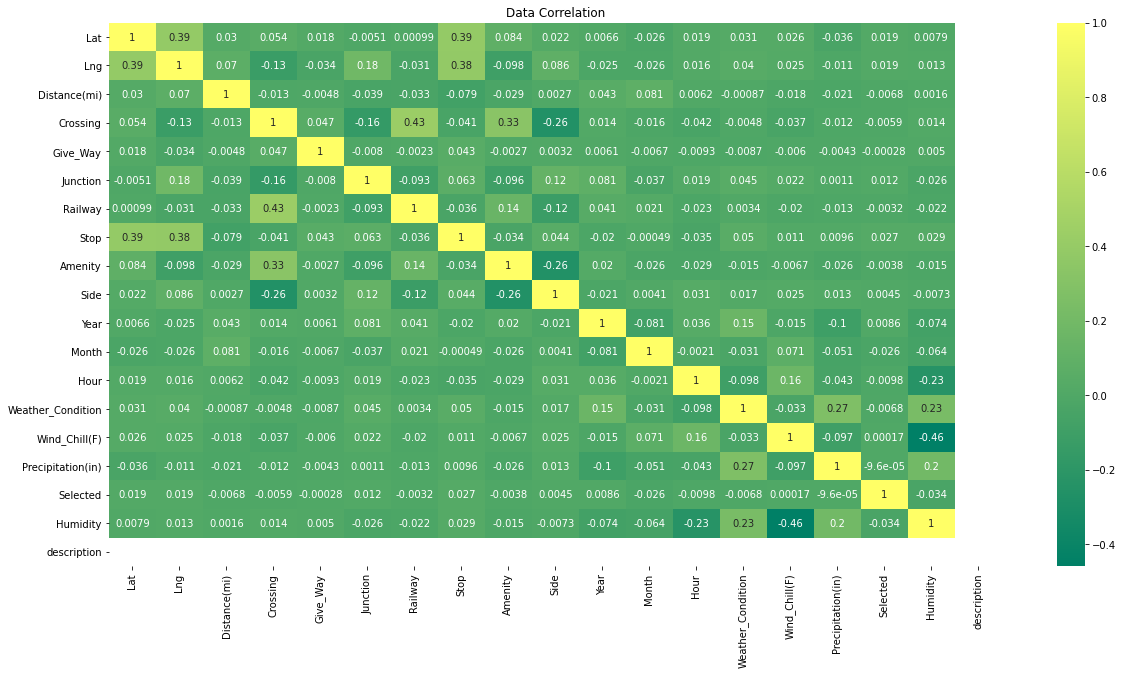

In [42]:
plt.figure(figsize=(20,10))
plt.title('Data Correlation')
sns.heatmap(X_train.corr(),annot= True,cmap='summer')

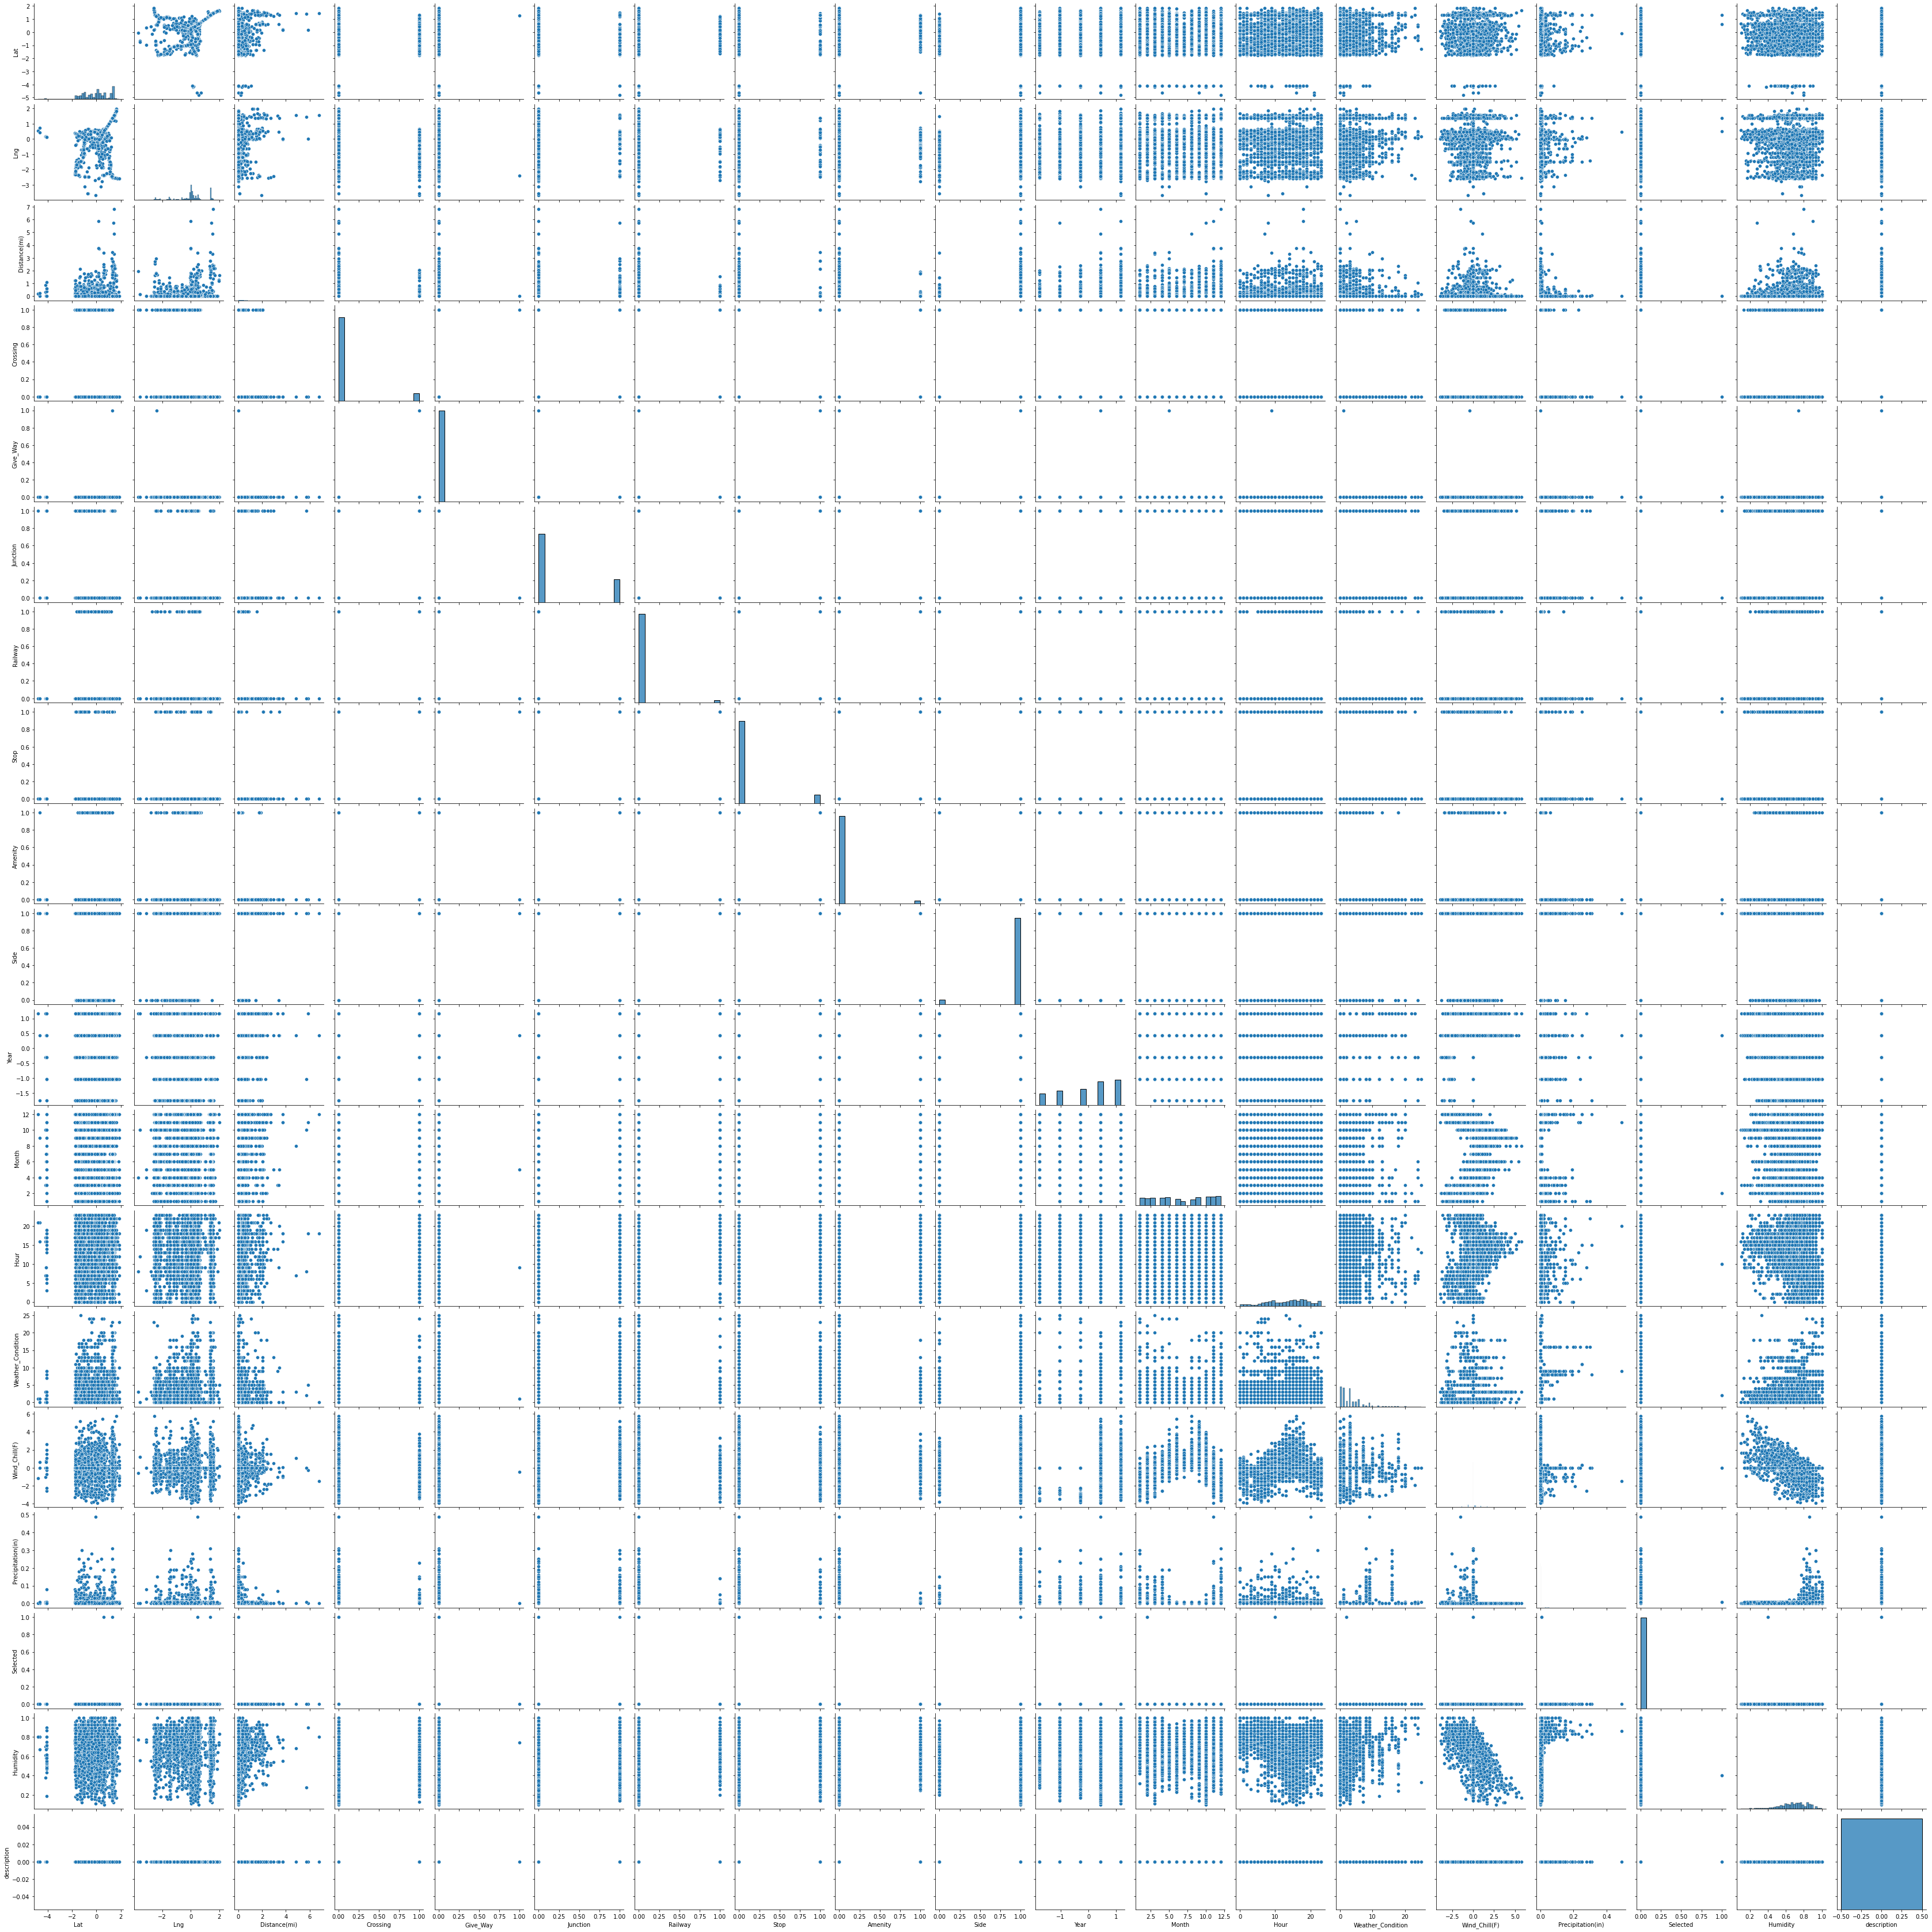

In [43]:
sns.pairplot(X_train)

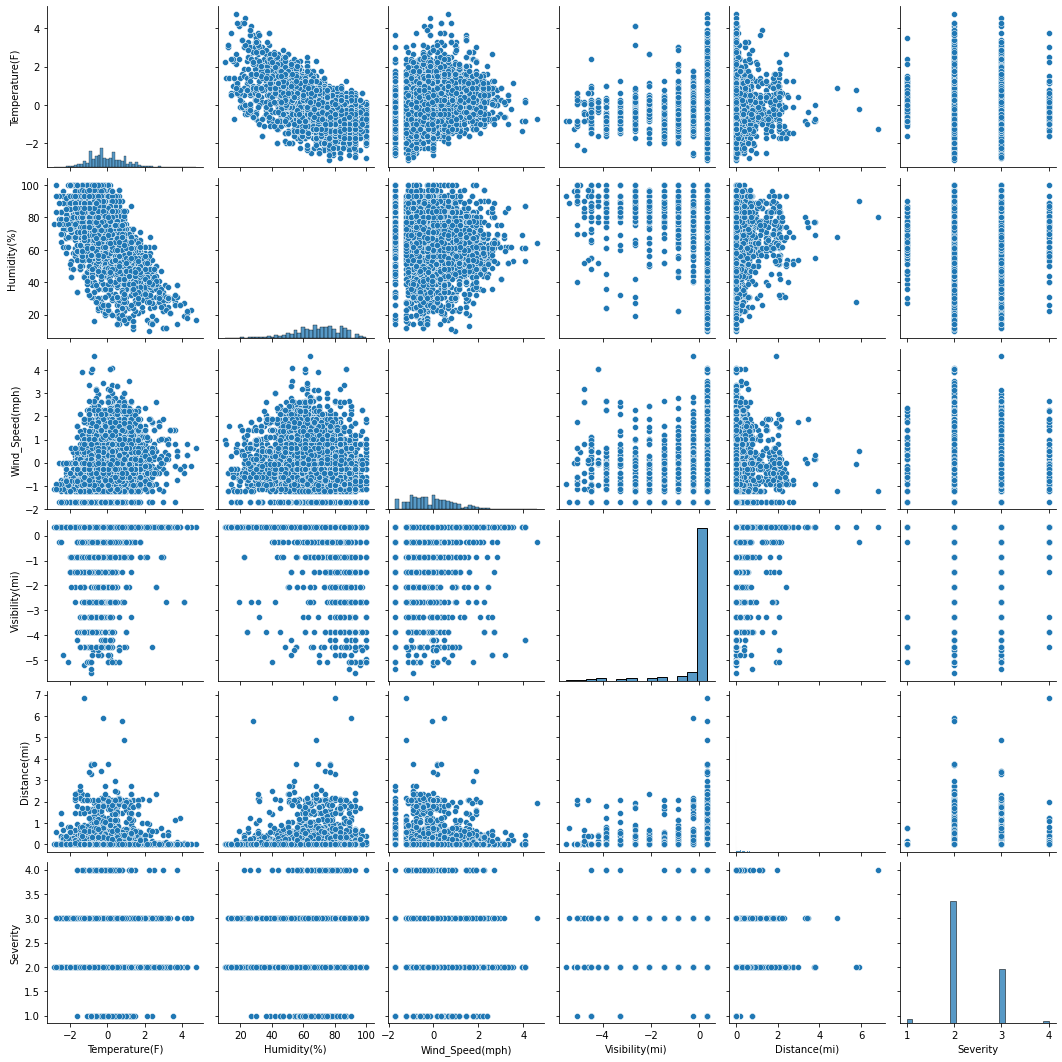

In [44]:
sns.pairplot(train_df[['Temperature(F)','Humidity(%)','Wind_Speed(mph)','Visibility(mi)', 'Distance(mi)', 'Severity']])

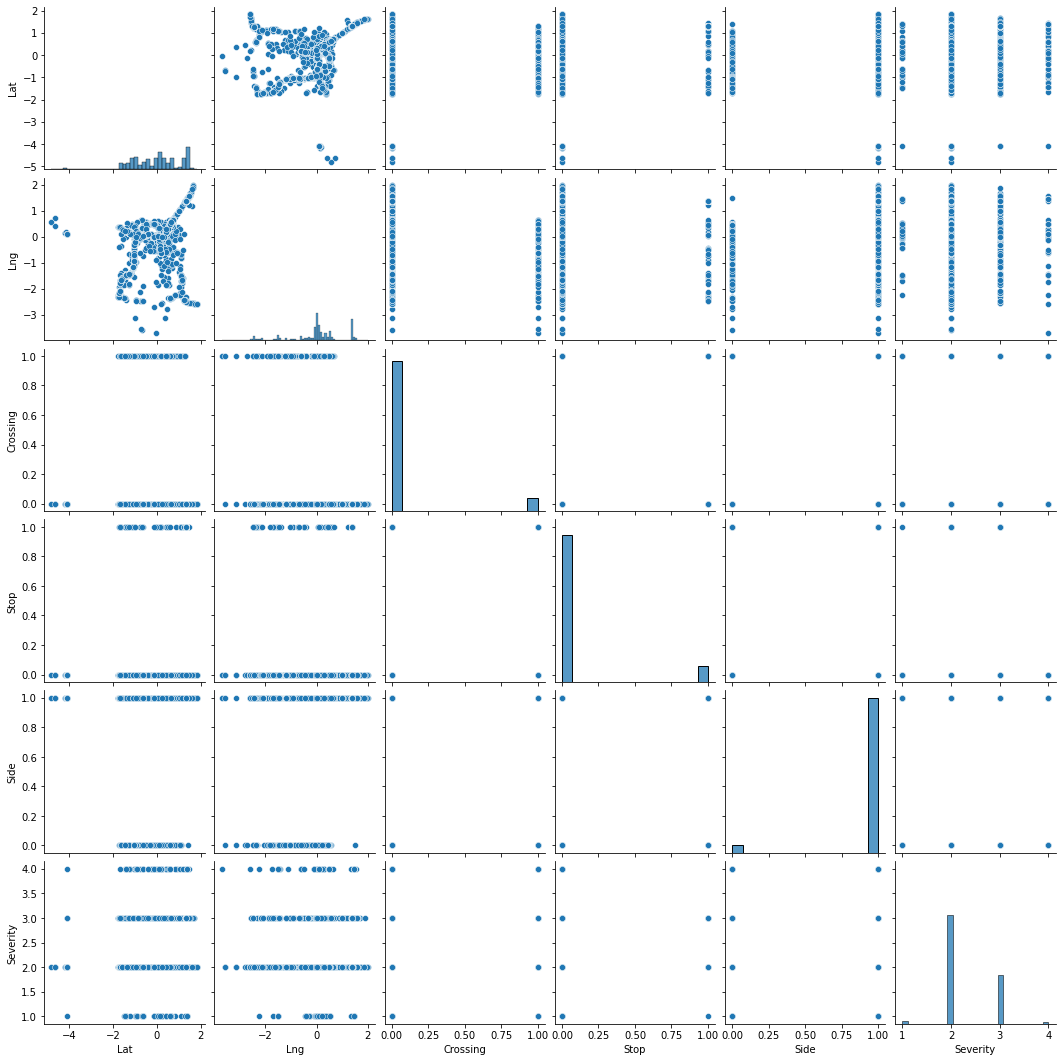

In [45]:
sns.pairplot(train_df[['Lat', 'Lng', 'Crossing', 'Stop', 'Side', 'Severity']])

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) # Try adding `stratify` here

X_train = train_df.drop(columns=['ID', 'Severity'])
y_train = train_df['Severity']

X_val = val_df.drop(columns=['ID', 'Severity'])
y_val = val_df['Severity']


As pointed out eariler, I'll use the numerical features to train the classifier. **However, you shouldn't use the numerical features only to make the final submission if you want to make it to the top of the leaderboard.** 

# This cell is used to select the numerical features. IT SHOULD BE REMOVED AS YOU DO YOUR WORK.
X_train = X_train[features]
X_val = X_val[features]

## Model Training

Let's train a model with the data! We'll train a Random Forest Classifier to demonstrate the process of making submissions. 

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier = classifier.fit(X_train, y_train)

Now let's test our classifier on the validation dataset and see the accuracy.

In [47]:
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.765807962529274


Well. That's a good start, right? A classifier that predicts all examples' `Severity` as 2 will get around 0.63. You should get better score as you add more features and do better data preprocessing.

## Submission File Generation

We have built a model and we'd like to submit our predictions on the test set! In order to do that, we'll load the test set, predict the class and save the submission file. 

First, we'll load the data.

In [48]:
test_df = pd.read_csv(os.path.join(dataset_path,'test.csv'))

X_test = merge_data(test_df)

# You should update/remove the next line once you change the features used for training
columns_removed = ['ID', 'Roundabout', 'Bump', 'Humidity(%)',
                   'No_Exit', 'Wind_Speed(mph)', 'Temperature(F)',
                   'Visibility(mi)', 'Day']
X_test = X_test.drop(columns=columns_removed)

y_test_predicted = classifier.predict(X_test)

test_df['Severity'] = y_test_predicted

test_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Year,Month,Day,Hour,Severity
0,6407,37.786060,-122.390900,False,0.039,False,False,True,False,False,False,False,False,R,2016,4,4,19,2
1,6408,37.769609,-122.415057,False,0.202,False,False,False,False,False,False,False,False,R,2020,10,28,11,2
2,6409,37.807495,-122.476021,False,0.000,False,False,False,False,False,False,False,False,R,2019,9,9,7,2
3,6410,37.761818,-122.405869,False,0.000,False,False,True,False,False,False,False,False,R,2019,8,6,15,2
4,6411,37.732350,-122.414100,False,0.670,False,False,False,False,False,False,False,False,R,2018,10,17,9,2


In [49]:
test_df[['ID', 'Severity']].to_csv('/kaggle/working/submission.csv', index=False)

test_df=StartProcess('../input/car-crashes-severity-prediction/weather-sfcsv.csv','../input/car-crashes-severity-prediction/test.csv','./holidays.csv',ch=2)

#ColumnsTF to replcae true and false Cloumns with Numeric Values 1 / 0
ColumnsTF = ['Bump', 'Crossing', 'Give_Way','Junction', 'No_Exit', 'Railway', 'Roundabout', 'Stop', 'Amenity']
#columnsmean Columns Names Wich Has Nan Values to replcae with Mean
columnsmean = ['Wind_Chill(F)',	'Precipitation(in)','Temperature(F)','Humidity(%)',	'Wind_Speed(mph)','Visibility(mi)'] 
#Replace DataFrame True False Values With Numeric Values
FillData(test_df,ColumnsTF,1)
#Replace DataFrame Nan Values With Numeric Values
FillData(test_df,columnsmean,0)
#drop String Cloumns Null Values 
stringNa = ['Weather_Condition']
FillData(test_df,stringNa,3,2)

test_df.isnull().values.sum()

test_df.describe()

test_df=test_df.apply(preprocessing.LabelEncoder().fit_transform)

normlizationList = ['Distance(mi)',	'Humidity(%)','Lat','Lng','Precipitation(in)','Side','Temperature(F)','Visibility(mi)',		'Wind_Chill(F)']
for i in range(len(normlizationList)):
    test_df[normlizationList[i]]=(test_df[normlizationList[i]]-test_df[normlizationList[i]].mean())/(test_df[normlizationList[i]].std())

X_test = test_df.drop(columns=['ID'])

X_test = X_test[features]

y_test_predicted = classifier.predict(X_test)

test_df['Severity'] = y_test_predicted

test_df.head()

Now we're ready to generate the submission file. The submission file needs the columns `ID` and `Severity` only.

The remaining steps is to submit the generated file and are as follows. 

1. Press `Save Version` on the upper right corner of this notebook.
2. Write a `Version Name` of your choice and choose `Save & Run All (Commit)` then click `Save`.
3. Wait for the saved notebook to finish running the go to the saved notebook.
4. Scroll down until you see the output files then select the `submission.csv` file and click `Submit`.

Now your submission will be evaluated and your score will be updated on the leaderboard! CONGRATULATIONS!!

## Conclusion

In this notebook, we have demonstrated the essential steps that one should do in order to get "slightly" familiar with the data and the submission process. We chose not to go into details in each step to keep the welcoming notebook simple and make a room for improvement.

You're encourged to `Fork` the notebook, edit it, add your insights and use it to create your submission.